# Task 1

In [107]:
import seaborn as sbn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as scs
import sklearn.model_selection as mdls
import sklearn.impute as imp
import sklearn.compose as comp
import sklearn.pipeline as pipe
import sklearn.preprocessing as prep
import sklearn.decomposition as decomp
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.ensemble as esb
import sklearn.metrics as met
from xgboost import XGBClassifier

In [108]:
# Setting a seed for reproducibility
seed = 1999
np.random.seed(seed)

## Exploratory data analysis

In [109]:
# The project is set as a R project (subfolders: data, rmd, iypnb, src) to facilitate use of relative paths
# Thus setting the path to the data as follows when on local notebook rather than on colab
# Leaving it for ease of changing
# data_file = os.path.join(os.path.realpath(".."), "data", "promotion_dataset.csv")

# Calling the data when on colab
from google.colab import drive
drive.mount("/content/drive/", force_remount = True) 
promo_raw = pd.read_csv("/content/drive/My Drive/!proj/applied_machine_learning_first_project/data/promotion_dataset.csv")
# Checking that the call was succesfull was printing the first 5 rows
print(promo_raw.head())
# # Shape will tell us the number of observations and confirm the total number of variables seen when printing head()
print(promo_raw.shape)

Mounted at /content/drive/
   employee_id         department  ... avg_training_score is_promoted
0        65438  Sales & Marketing  ...                 49           0
1        65141         Operations  ...                 60           0
2         7513  Sales & Marketing  ...                 50           0
3         2542  Sales & Marketing  ...                 50           0
4        48945         Technology  ...                 73           0

[5 rows x 13 columns]
(54808, 13)


In [110]:
# Inspecting the data type of each attribute, as well as if there are missing values, in one line
# The missing values will be dealt with later, in the machine learning pipeline
promo_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
 12  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


In [111]:
# At this stage, we need to discard the ID as it is not a meaningful attribute and would introduce noise in the models
# We should also rename awards_won? without the "?" for ease of manipulation
promo_raw.rename(columns = {"awards_won?": "awards_won"}, inplace = True)
promo = promo_raw.drop(["employee_id"], axis = 1)
# Then we need to set the categorical variables as such (for example, awards_won is numerical), so we can apply appropriate
# exploratory analyses (before hot encoding them); 
promo.awards_won.astype(object)
# Inspecting descriptive statistics for each variable, with focus on top (mode) and unique (number of categories)
# for categorical variables, and mean, median, minimun and maximum for numerical variables
print(promo.describe(include = "all"))

               department    region  ... avg_training_score   is_promoted
count               54808     54808  ...       54808.000000  54808.000000
unique                  9        34  ...                NaN           NaN
top     Sales & Marketing  region_2  ...                NaN           NaN
freq                16840     12343  ...                NaN           NaN
mean                  NaN       NaN  ...          63.386750      0.085170
std                   NaN       NaN  ...          13.371559      0.279137
min                   NaN       NaN  ...          39.000000      0.000000
25%                   NaN       NaN  ...          51.000000      0.000000
50%                   NaN       NaN  ...          60.000000      0.000000
75%                   NaN       NaN  ...          76.000000      0.000000
max                   NaN       NaN  ...          99.000000      1.000000

[11 rows x 12 columns]


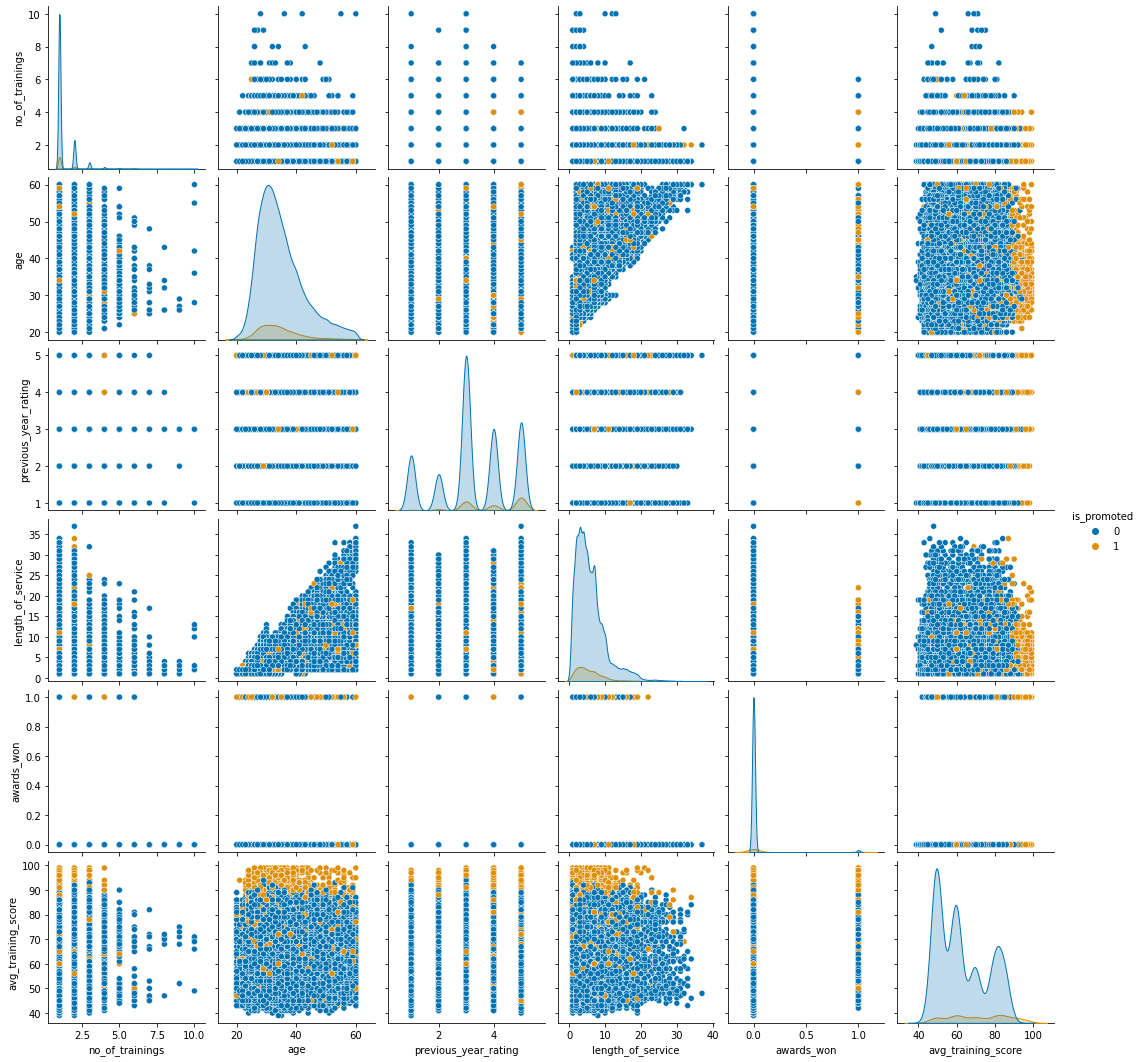

In [112]:
# Then we can have a first global inspection of the distributions and the pairwise relationships, considering the class,
# using a pair plot
print(sbn.pairplot(promo, hue = "is_promoted", palette = "colorblind"))

In [113]:
# What is immediately apparent from the pair plot is the imbalance in the class, so we can get exact values for these,
# to assess the extent of the imbalance
pct_promoted = len(promo[promo["is_promoted"] == 1]) / len(promo)
print(pct_promoted)

0.08517004816815063


In [114]:
# Exploring further the apparent strong correlation between age and length of service
print(scs.spearmanr(promo.age, promo.length_of_service))

SpearmanrResult(correlation=0.644444228689948, pvalue=0.0)


In [115]:
# Pair plot does not allow to look at the associations between categorical variables, so we also need to compute a few
# crosstabs against the class, starting with the relationship with the employee's department
round(pd.crosstab(promo.department, promo.is_promoted, normalize = "index"), 2)


is_promoted           0     1
department                   
Analytics          0.90  0.10
Finance            0.92  0.08
HR                 0.94  0.06
Legal              0.95  0.05
Operations         0.91  0.09
Procurement        0.90  0.10
R&D                0.93  0.07
Sales & Marketing  0.93  0.07
Technology         0.89  0.11

In [116]:
round(pd.crosstab(promo.gender, promo.is_promoted, normalize = "index"), 2)

is_promoted     0     1
gender                 
f            0.91  0.09
m            0.92  0.08

In [117]:
round(pd.crosstab(promo.region, promo.is_promoted, normalize = "index"), 2)

is_promoted     0     1
region                 
region_1     0.90  0.10
region_10    0.92  0.08
region_11    0.94  0.06
region_12    0.93  0.07
region_13    0.91  0.09
region_14    0.93  0.07
region_15    0.92  0.08
region_16    0.93  0.07
region_17    0.86  0.14
region_18    0.97  0.03
region_19    0.94  0.06
region_2     0.92  0.08
region_20    0.94  0.06
region_21    0.96  0.04
region_22    0.89  0.11
region_23    0.88  0.12
region_24    0.96  0.04
region_25    0.87  0.13
region_26    0.94  0.06
region_27    0.92  0.08
region_28    0.88  0.12
region_29    0.96  0.04
region_3     0.89  0.11
region_30    0.91  0.09
region_31    0.94  0.06
region_32    0.96  0.04
region_33    0.96  0.04
region_34    0.97  0.03
region_4     0.86  0.14
region_5     0.95  0.05
region_6     0.95  0.05
region_7     0.89  0.11
region_8     0.92  0.08
region_9     0.98  0.02

In [118]:
round(pd.crosstab(promo.education, promo.is_promoted, normalize = "index"), 2)

is_promoted          0     1
education                   
Bachelor's        0.92  0.08
Below Secondary   0.92  0.08
Master's & above  0.90  0.10

In [119]:
round(pd.crosstab(promo.recruitment_channel, promo.is_promoted, normalize = "index"), 2)

is_promoted             0     1
recruitment_channel            
other                0.92  0.08
referred             0.88  0.12
sourcing             0.91  0.09

In [120]:
round(pd.crosstab(promo.awards_won, promo.is_promoted, normalize = "index"), 2)

is_promoted     0     1
awards_won             
0            0.92  0.08
1            0.56  0.44

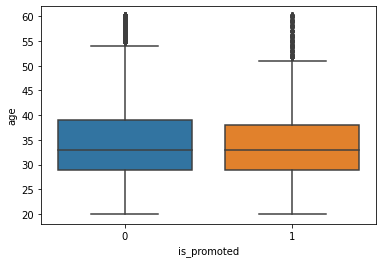

In [121]:
# Visually checking for outliers on the numerical variables
sbn.boxplot(y = promo.age, x = promo.is_promoted)

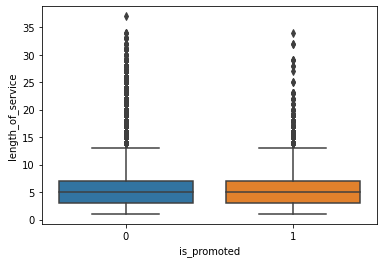

In [122]:
sbn.boxplot(y = promo.length_of_service, x = promo.is_promoted)

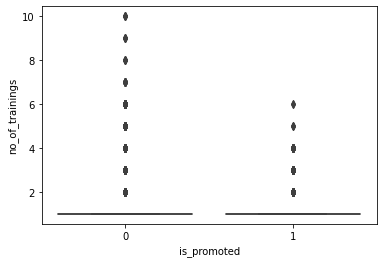

In [123]:
sbn.boxplot(y = promo.no_of_trainings, x = promo.is_promoted)

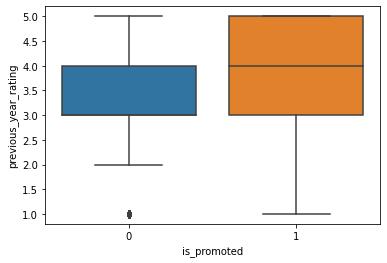

In [124]:
sbn.boxplot(y = promo.previous_year_rating, x = promo.is_promoted)

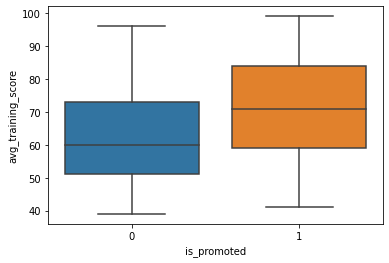

In [125]:
sbn.boxplot(y = promo.avg_training_score, x = promo.is_promoted)

## Building the pipeline

In [126]:
# Dropping the missing values rows before splitting
promo_reduced = promo.dropna()
promo_reduced = promo_reduced.drop("region", axis = 1)
promo_reduced.info()

# Preparing the full dataset before splitting for steps that do not involve algorithms learning
X = promo_reduced.drop(columns = ["is_promoted"])
y = promo_reduced.is_promoted


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48660 entries, 0 to 54807
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            48660 non-null  object 
 1   education             48660 non-null  object 
 2   gender                48660 non-null  object 
 3   recruitment_channel   48660 non-null  object 
 4   no_of_trainings       48660 non-null  int64  
 5   age                   48660 non-null  int64  
 6   previous_year_rating  48660 non-null  float64
 7   length_of_service     48660 non-null  int64  
 8   awards_won            48660 non-null  int64  
 9   avg_training_score    48660 non-null  int64  
 10  is_promoted           48660 non-null  int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 4.5+ MB


In [127]:
# Defining the numerical and categorical attributes, as well as all the variables kept so far, so they can be passed
# into the pipeline steps as needed
all_var = promo_reduced.columns

# awards_won needs to be excluded however, as it is already hot encoded as binary variable
X_temp = X.drop(["awards_won"], axis = 1)
promo_num = X_temp.select_dtypes(exclude = ["object"]).columns

promo_cat = X_temp.select_dtypes(include = ["object"]).columns

In [128]:
# Pre-processing sequence, including:
# preliminary feature reduction, missing values imputation, one hot (dummy) encoding, scaling (with outliers management)
pre_proc = comp.ColumnTransformer(remainder = "passthrough",
                                transformers = [("cat", imp.SimpleImputer(strategy = "most_frequent", copy = False), promo_cat),
                                                ("dummy", prep.OneHotEncoder(drop = "first", sparse = False), promo_cat),
                                                ("scaling", prep.PowerTransformer(copy = False), promo_num)
                                               ])
X_prep = pre_proc.fit_transform(X)

# Dropping the original categorical variables after pre-processing
X_prep = np.delete(X_prep, slice(0, 4), 1)

In [129]:
# Now splitting before using PCA for further data preparation so the dimensionality reduction is only based on the training set

X_train, X_test, y_train, y_test = mdls.train_test_split(
    X_prep,
    y,
    test_size = 0.25,
    random_state = seed,
    stratify = promo_reduced.is_promoted)

# Using PCA for dimensionality reduction
# Code adapted from https://medium.com/@andymdc31/using-pca-in-a-machine-learning-pipeline-b6fe3492b1b9
pca = decomp.PCA()
X_pca = pca.fit_transform(X_train)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X.shape[1] - n_over_95 + 1

(12165,) (12165,)
SVM, confusion matrix values: [[11107     0]
 [ 1058     0]], test acc:0.9130291820797369
(12165,) (12165,)
RandomForest, confusion matrix values: [[11107     0]
 [ 1058     0]], test acc:0.9130291820797369
(12165,) (12165,)
XGB, confusion matrix values: [[11103     4]
 [ 1056     2]], test acc:0.9128647759967119


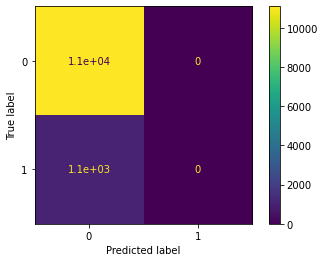

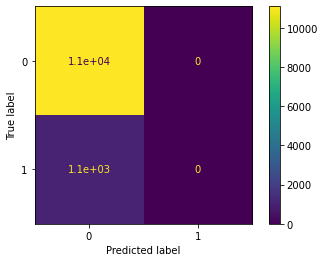

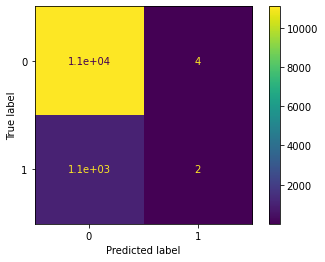

In [130]:
# Building the pipeline for the three chosen models plus application of PCA
# Adapting the class code and this code https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
def eval_model(model_name, X_train_prep, X_test, y_train, y_test):
    if model_name == "RandomForest":
        model = pipe.make_pipeline(decomp.PCA(n_components = n_to_reach_95),
                                   esb.RandomForestClassifier(max_depth = 3, random_state= seed, n_estimators = 10))
    elif model_name == "SVM":
        model = pipe.make_pipeline(decomp.PCA(n_components = n_to_reach_95),
                                   svm.SVC(kernel = "linear"))
    elif model_name == "XGB":
        model = pipe.make_pipeline(decomp.PCA(n_components = n_to_reach_95),
                                   XGBClassifier(
                                       learning_rate = 0.1,
                                       n_estimators = 1000,
                                       max_depth = 5,
                                       min_child_weight = 1,
                                       gamma = 0,
                                       subsample = 0.8,
                                       colsample_bytree = 0.8,
                                       objective = "binary:logistic",
                                       nthread = 4,
                                       scale_pos_weight = 1,
                                       seed = seed))
                                   
                            
    model.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    print(pred_test.shape, y_test.shape)
    test_acc = met.accuracy_score(y_test, pred_test)
    cm_values = met.confusion_matrix(y_test, pred_test)
    cm = met.plot_confusion_matrix(model, X_test, y_test)  

    print(f"{model_name}, confusion matrix values: {cm_values}, test acc:{test_acc}")
    print(cm)

eval_model("SVM", X_train, X_test, y_train, y_test)
eval_model("RandomForest", X_train, X_test, y_train, y_test)
eval_model("XGB", X_train, X_test, y_train, y_test)


(12165,) (12165,)
SVM, confusion matrix values: [[11107     0]
 [  916   142]], test acc:0.924702013974517
(12165,) (12165,)
RandomForest, confusion matrix values: [[11107     0]
 [ 1023    35]], test acc:0.9159062885326757
(12165,) (12165,)
XGB, confusion matrix values: [[11070    37]
 [  675   383]], test acc:0.9414714344430744


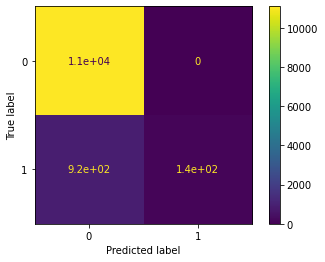

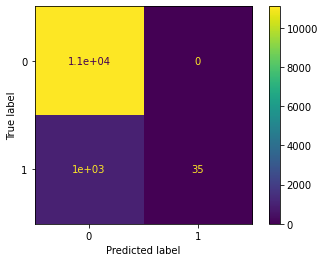

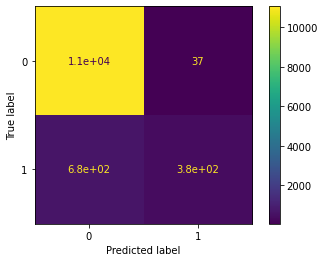

In [131]:
# It was observed building the planned pipeline above that metrics improved for the Random forest model when the PCA step
# was not included, so a fine-tuning run is tested below.

# Building the pipeline for the three chosen models plus application of PCA
# Adapting the class code with this code https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
def eval_model_no_PCA(model_name, X_train_prep, X_test, y_train, y_test):
    if model_name == "RandomForest":
        model = pipe.make_pipeline(esb.RandomForestClassifier(max_depth = 3, random_state= seed, n_estimators = 10))
    elif model_name == "SVM":
        model = pipe.make_pipeline(svm.SVC(kernel = "linear"))
    elif model_name == "XGB":
        model = pipe.make_pipeline(XGBClassifier(
                                       learning_rate = 0.1,
                                       n_estimators = 1000,
                                       max_depth = 5,
                                       min_child_weight = 1,
                                       gamma = 0,
                                       subsample = 0.8,
                                       colsample_bytree = 0.8,
                                       objective = "binary:logistic",
                                       nthread = 4,
                                       scale_pos_weight = 1,
                                       seed = seed))
                                   
                            
    model.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    print(pred_test.shape, y_test.shape)
    test_acc = met.accuracy_score(y_test, pred_test)
    cm_values = met.confusion_matrix(y_test, pred_test)
    cm = met.plot_confusion_matrix(model, X_test, y_test)  

    print(f"{model_name}, confusion matrix values: {cm_values}, test acc:{test_acc}")
    print(cm)

eval_model_no_PCA("SVM", X_train, X_test, y_train, y_test)
eval_model_no_PCA("RandomForest", X_train, X_test, y_train, y_test)
eval_model_no_PCA("XGB", X_train, X_test, y_train, y_test)


## Re-pre-processing the data to test the same models without gender

In [132]:
# Preparing the full dataset before splitting for steps that do not involve algorithms learning
X_no_gd = X.drop(columns = ["gender"])

# Defining the numerical and categorical attributes, as well as all the variables kept so far, so they can be passed
# into the pipeline steps as needed
all_var = promo_reduced_no_gd.columns

# awards_won needs to be excluded however, as it is already hot encoded as binary variable
X_no_gd_temp = X.drop(["awards_won"], axis = 1)
promo_num = X_no_gd.select_dtypes(exclude = ["object"]).columns

promo_cat = X_no_gd.select_dtypes(include = ["object"]).columns
promo_num

# Pre-processing sequence, including:
# preliminary feature reduction, missing values imputation, one hot (dummy) encoding, scaling (with outliers management)
pre_proc = comp.ColumnTransformer(remainder = "passthrough",
                                transformers = [("cat", imp.SimpleImputer(strategy = "most_frequent", copy = False), promo_cat),
                                                ("dummy", prep.OneHotEncoder(drop = "first", sparse = False), promo_cat),
                                                ("scaling", prep.PowerTransformer(copy = False), promo_num)
                                               ])
X_no_gd_prep = pre_proc.fit_transform(X_no_gd)

# Dropping the original categorical variables after pre-processing
X_no_gd_prep = np.delete(X_no_gd_prep, slice(0, 3), 1)

# Now splitting before using PCA for further data preparation so the dimensionality reduction is only based on the training set

X_train, X_test, y_train, y_test = mdls.train_test_split(
    X_no_gd_prep,
    y,
    test_size = 0.25,
    random_state = seed,
    stratify = promo_reduced.is_promoted)

(12165,) (12165,)
SVM, confusion matrix values: [[11107     0]
 [ 1058     0]], test acc:0.9130291820797369
(12165,) (12165,)
RandomForest, confusion matrix values: [[11070    37]
 [  982    76]], test acc:0.9162351006987258
(12165,) (12165,)
XGB, confusion matrix values: [[11036    71]
 [  963    95]], test acc:0.9150020550760378


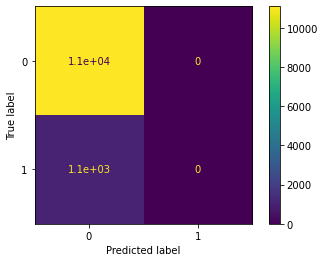

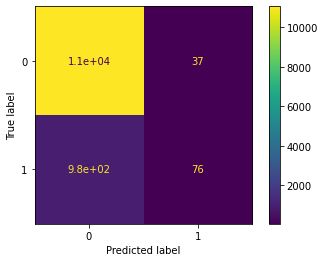

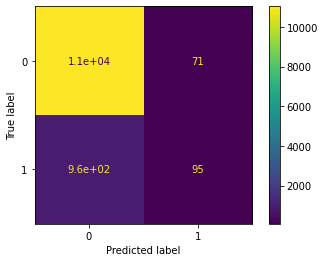

In [133]:
X_no_gd_pca = pca.fit_transform(X_train)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95_no_gd = X.shape[1] - n_over_95 + 1

def eval_model(model_name, X_train_prep, X_test, y_train, y_test):
    if model_name == "RandomForest":
        model = pipe.make_pipeline(decomp.PCA(n_components = n_to_reach_95_no_gd),
                                   esb.RandomForestClassifier(max_depth = 3, random_state= seed, n_estimators = 10))
    elif model_name == "SVM":
        model = pipe.make_pipeline(decomp.PCA(n_components = n_to_reach_95_no_gd),
                                   svm.SVC(kernel = "linear"))
    elif model_name == "XGB":
        model = pipe.make_pipeline(decomp.PCA(n_components = n_to_reach_95_no_gd),
                                   XGBClassifier(
                                       learning_rate = 0.1,
                                       n_estimators = 1000,
                                       max_depth = 5,
                                       min_child_weight = 1,
                                       gamma = 0,
                                       subsample = 0.8,
                                       colsample_bytree = 0.8,
                                       objective = "binary:logistic",
                                       nthread = 4,
                                       scale_pos_weight = 1,
                                       seed = seed))
                                   
                            
    model.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    print(pred_test.shape, y_test.shape)
    test_acc = met.accuracy_score(y_test, pred_test)
    cm_values = met.confusion_matrix(y_test, pred_test)
    cm = met.plot_confusion_matrix(model, X_test, y_test)  

    print(f"{model_name}, confusion matrix values: {cm_values}, test acc:{test_acc}")
    print(cm)

eval_model("SVM", X_train, X_test, y_train, y_test)
eval_model("RandomForest", X_train, X_test, y_train, y_test)
eval_model("XGB", X_train, X_test, y_train, y_test)

(12165,) (12165,)
SVM, confusion matrix values: [[11107     0]
 [  917   141]], test acc:0.9246198109330045
(12165,) (12165,)
RandomForest, confusion matrix values: [[11107     0]
 [ 1044    14]], test acc:0.9141800246609124
(12165,) (12165,)
XGB, confusion matrix values: [[11067    40]
 [  684   374]], test acc:0.940484997944924


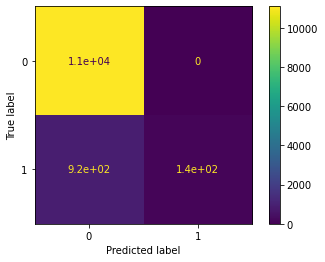

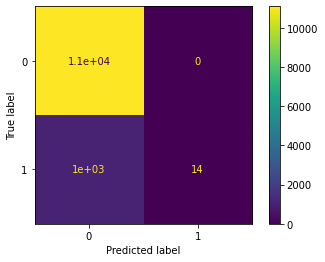

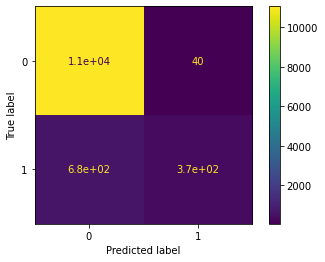

In [134]:
def eval_model_no_PCA(model_name, X_train_prep, X_test, y_train, y_test):
    if model_name == "RandomForest":
        model = pipe.make_pipeline(esb.RandomForestClassifier(max_depth = 3, random_state= seed, n_estimators = 10))
    elif model_name == "SVM":
        model = pipe.make_pipeline(svm.SVC(kernel = "linear"))
    elif model_name == "XGB":
        model = pipe.make_pipeline(XGBClassifier(
                                       learning_rate = 0.1,
                                       n_estimators = 1000,
                                       max_depth = 5,
                                       min_child_weight = 1,
                                       gamma = 0,
                                       subsample = 0.8,
                                       colsample_bytree = 0.8,
                                       objective = "binary:logistic",
                                       nthread = 4,
                                       scale_pos_weight = 1,
                                       seed = seed))
                                   
                            
    model.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    print(pred_test.shape, y_test.shape)
    test_acc = met.accuracy_score(y_test, pred_test)
    cm_values = met.confusion_matrix(y_test, pred_test)
    cm = met.plot_confusion_matrix(model, X_test, y_test)  

    print(f"{model_name}, confusion matrix values: {cm_values}, test acc:{test_acc}")
    print(cm)


eval_model_no_PCA("SVM", X_train, X_test, y_train, y_test)
eval_model_no_PCA("RandomForest", X_train, X_test, y_train, y_test)
eval_model_no_PCA("XGB", X_train, X_test, y_train, y_test)

# Task 2